In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import polars as pl

dataPath = ""

In [2]:
train_basetable = pd.read_csv("csv_files/train/train_base.csv")

In [3]:
train_basetable

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1
...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0
1526655,2703451,2020-10-05,202010,91,0
1526656,2703452,2020-10-05,202010,91,0
1526657,2703453,2020-10-05,202010,91,0


In [4]:
train_basetable['date_decision'] = pd.to_datetime(train_basetable['date_decision'])

In [5]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [6]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [7]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [8]:
data

case_id,date_decision,MONTH,WEEK_NUM,target,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,disbursedcredamount_1113A,downpmt_116A,inittransactionamount_650A,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastcancelreason_561M,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectreason_759M,lastrejectreasonclient_4145040M,maininc_215A,maxannuity_159A,maxannuity_4075009A,maxdebt4_972A,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,previouscontdistrict_112M,price_1097A,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,mainoccupationinc_384A_max,mainoccupationinc_384A_any_selfemployed,person_housetype,pmts_pmtsoverdue_635A_max,pmts_dpdvalue_108P_over31
i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,str,f64,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,bool,str,f64,bool
0,"""2019-01-03""",201901,0,0,null,1917.6,0.0,null,null,null,null,30000.0,0.0,0.0,30000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,10800.0,false,null,null,null
1,"""2019-01-03""",201901,0,0,null,3134.0,0.0,null,null,null,null,19999.8,0.0,0.0,19999.8,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,10000.0,false,null,null,null
2,"""2019-01-04""",201901,0,0,null,4937.0,0.0,null,null,null,null,78000.0,0.0,0.0,78000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",10000.0,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,14000.0,false,null,null,null
3,"""2019-01-03""",201901,0,0,null,4643.6,0.0,null,null,null,null,40000.0,0.0,0.0,40000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""P94_109_143""",null,null,"""a55475b1""","""a55475b1""",59999.8,"""P94_109_143""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,10000.0,false,null,null,null
4,"""2019-01-04""",201901,0,1,null,3390.2,0.0,null,null,null,null,44000.0,0.0,0.0,44000.0,0.0,null,"""a55475b1""","""a55475b1""",null,"""P24_27_36""",null,null,"""a55475b1""","""a55475b1""",null,"""a55475b1""","""a55475b1""",null,0.0,null,0.0,null,null,null,null,"""a55475b1""",null,null,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,24000.0,false,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2703450,"""2020-10-05""",202010,91,0,176561.36,3675.4001,0.0,7356.8003,null,16392.496,6750.2,30000.0,0.0,0.0,30000.0,0.0,null,"""P12_6_178""","""P142_50_170""",20020.0,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",150000.0,"""P94_109_143""","""P94_109_143""",36000.0,75521.91,null,105019.79,46718.2,49651.402,77533.76,14346.319,"""P123_39_170""",0.0,0.0,0.0,0.0,428159.66,14346.319,"""2fc785b2""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,12155.0,null,40000.0,false,"""OWNED""",nul

In [9]:
pd_data = data.to_pandas()

In [11]:
pd_data.dtypes

case_id                                      int64
date_decision                               object
MONTH                                        int64
WEEK_NUM                                     int64
target                                       int64
amtinstpaidbefduel24m_4187115A             float64
annuity_780A                               float64
annuitynextmonth_57A                       float64
avginstallast24m_3658937A                  float64
avglnamtstart24m_4525187A                  float64
avgoutstandbalancel6m_4187114A             float64
avgpmtlast12m_4525200A                     float64
credamount_770A                            float64
currdebt_22A                               float64
currdebtcredtyperange_828A                 float64
disbursedcredamount_1113A                  float64
downpmt_116A                               float64
inittransactionamount_650A                 float64
lastapprcommoditycat_1041M                  object
lastapprcommoditytypec_5251766M

In [12]:
pd_data['date_decision'] = pd.to_datetime(pd_data['date_decision'])

In [13]:
pd_data

,case_id,date_decision,MONTH,WEEK_NUM,target,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,...,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,mainoccupationinc_384A_max,mainoccupationinc_384A_any_selfemployed,person_housetype,pmts_pmtsoverdue_635A_max,pmts_dpdvalue_108P_over31
0,0,2019-01-03,201901,0,0,NaN,1917.6000,0.0,NaN,NaN,...,None,NaN,NaN,NaN,NaN,10800.0,False,None,NaN,None
1,1,2019-01-03,201901,0,0,NaN,3134.0000,0.0,NaN,NaN,...,None,NaN,NaN,NaN,NaN,10000.0,False,None,NaN,None
2,2,2019-01-04,201901,0,0,NaN,4937.0000,0.0,NaN,NaN,...,None,NaN,NaN,NaN,NaN,14000.0,False,None,NaN,None
3,3,2019-01-03,201901,0,0,NaN,4643.6000,0.0,NaN,NaN,...,None,NaN,NaN,NaN,NaN,10000.0,False,None,NaN,None
4,4,2019-01-04,201901,0,1,NaN,3390.2000,0.0,NaN,NaN,...,None,NaN,NaN,NaN,NaN,24000.0,False,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,176561.36,3675.4001,0.0,7356.8003,NaN,...,a55475b1,NaN,NaN,12155.0,NaN,40000.0,False,OWNED,NaN,None
1526655,2703451,2020-10-05,202010,91,0,301276.47,7088.6000,6191.6,12553.2000,NaN,...,a55475b1,NaN,NaN,22904.6,NaN,36800.0,False,None,NaN,None
1526656,2703452,2020-10-05,202010,91,0,14232.40,7788.8003,0.0,2662.4001,NaN,...,a55475b1,NaN,NaN,NaN,NaN,30000.0,False,None,NaN,None
1526657,2703453,2020-10-05,202010,91,0,197371.58,1195.4000,2827.2,8212.6010,NaN,...,a55475b1,NaN,NaN,15792.4,NaN,30000.0,False,None,NaN,None


case_id


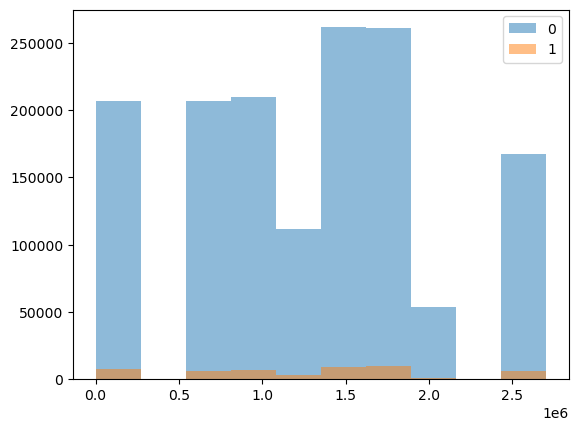

MONTH


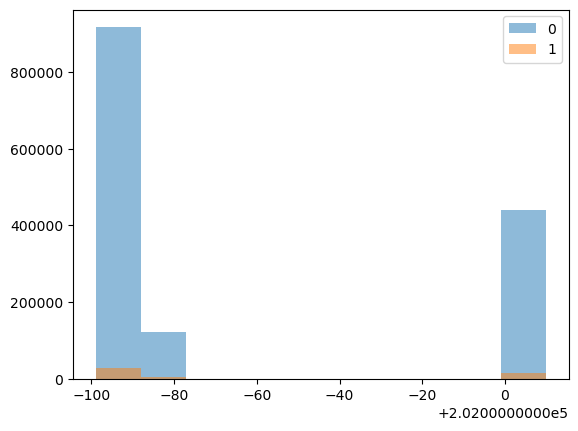

WEEK_NUM


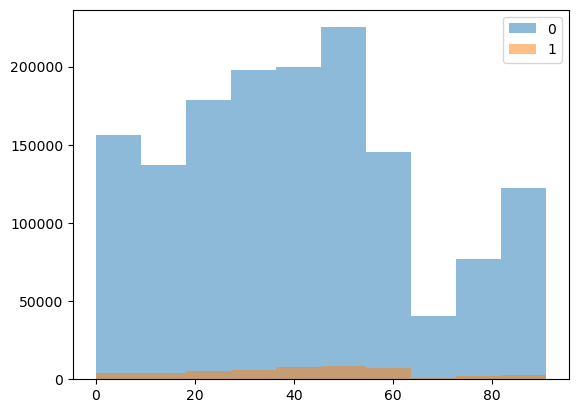

target


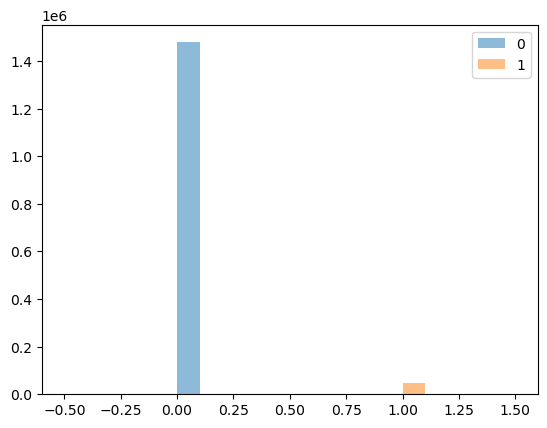

amtinstpaidbefduel24m_4187115A


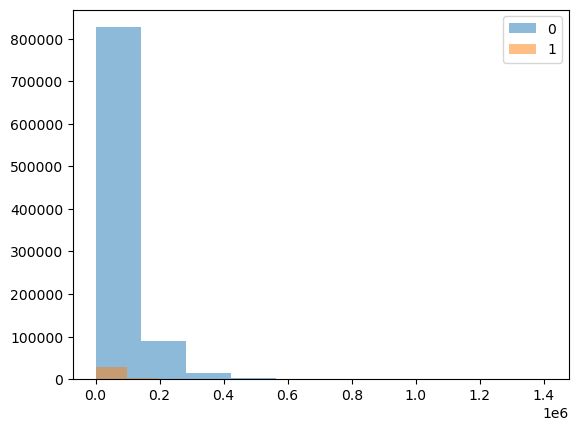

annuity_780A


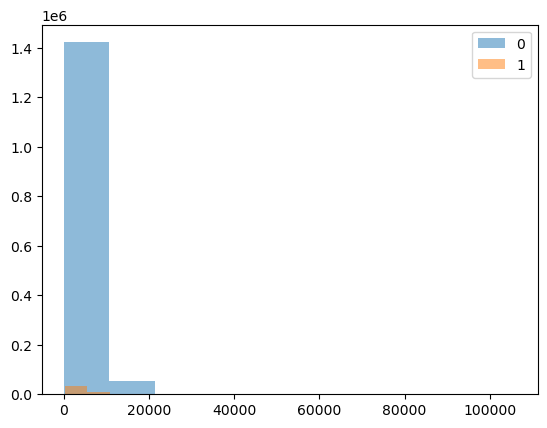

annuitynextmonth_57A


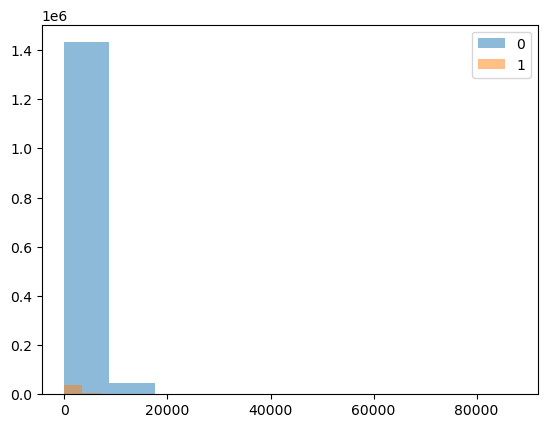

avginstallast24m_3658937A


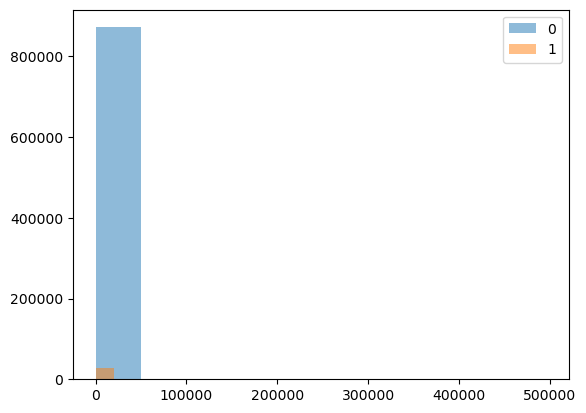

avglnamtstart24m_4525187A


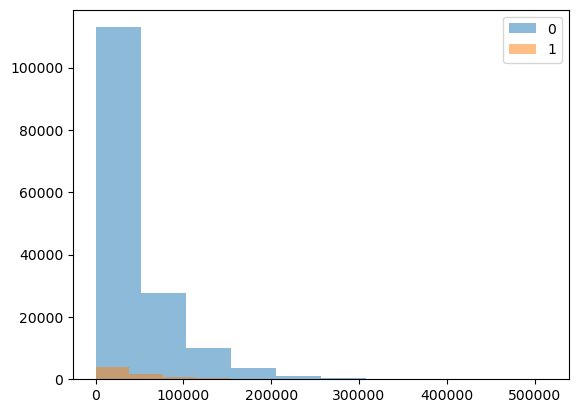

avgoutstandbalancel6m_4187114A


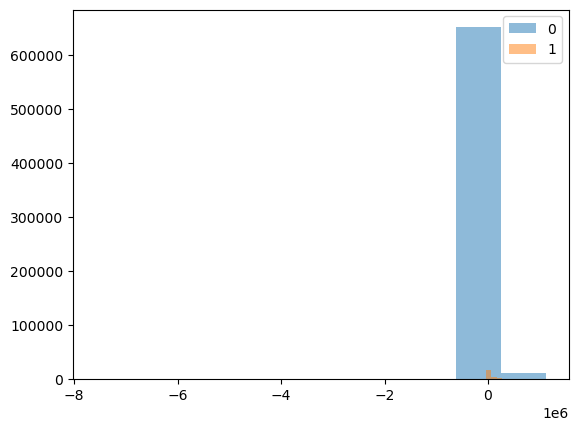

avgpmtlast12m_4525200A


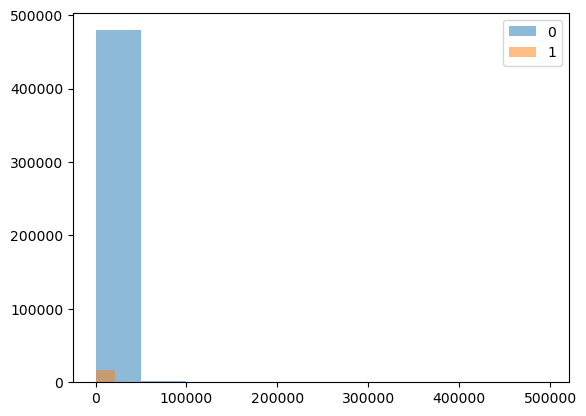

credamount_770A


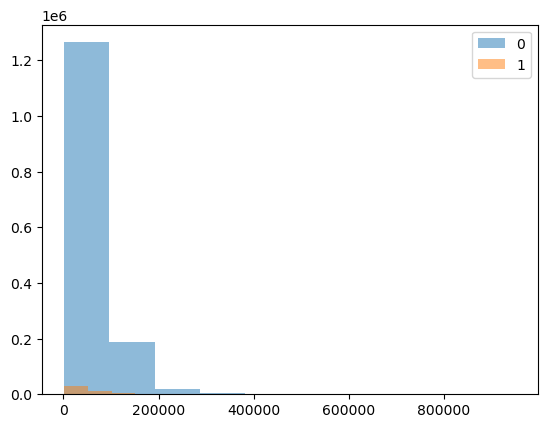

currdebt_22A


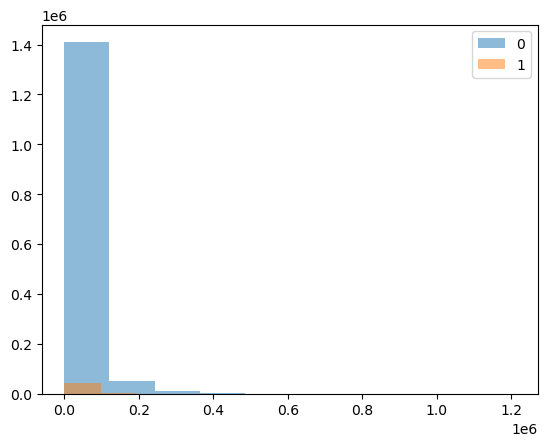

currdebtcredtyperange_828A


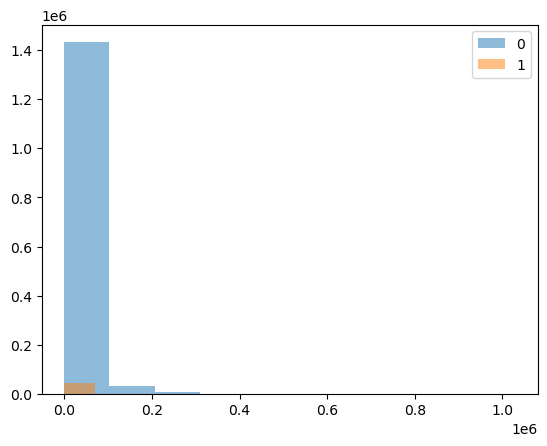

disbursedcredamount_1113A


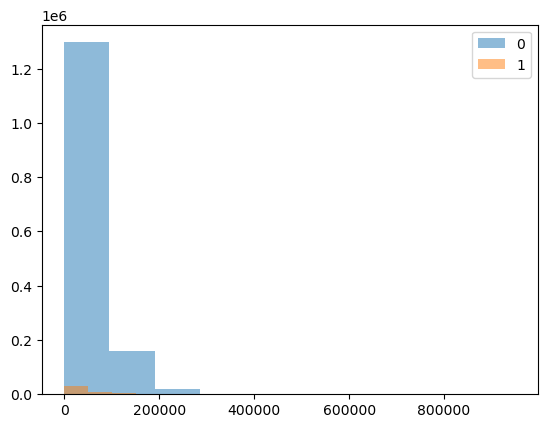

downpmt_116A


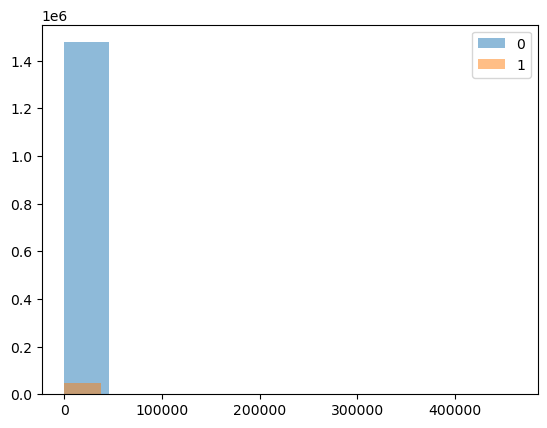

inittransactionamount_650A


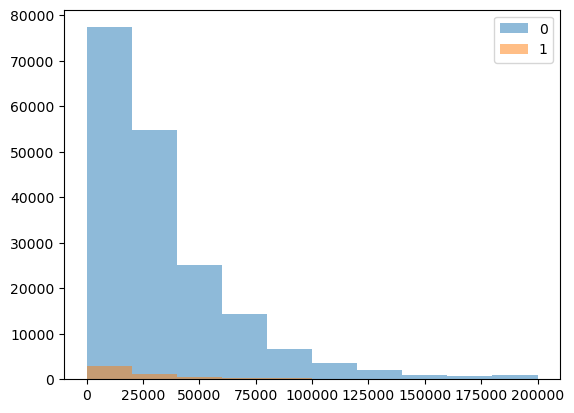

lastapprcredamount_781A


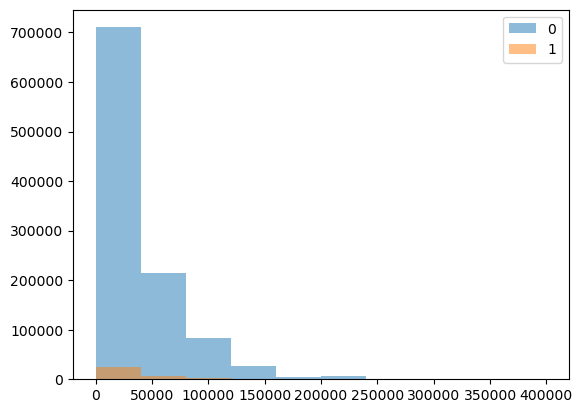

lastotherinc_902A


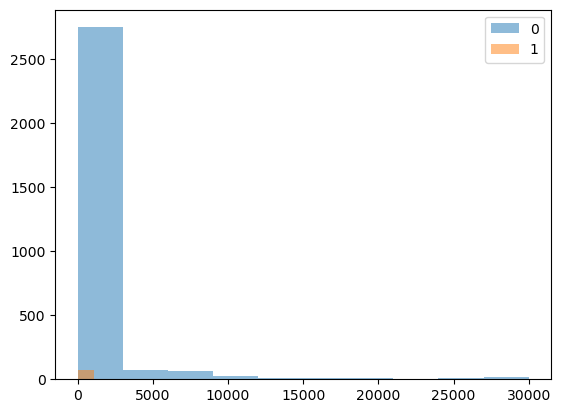

lastotherlnsexpense_631A


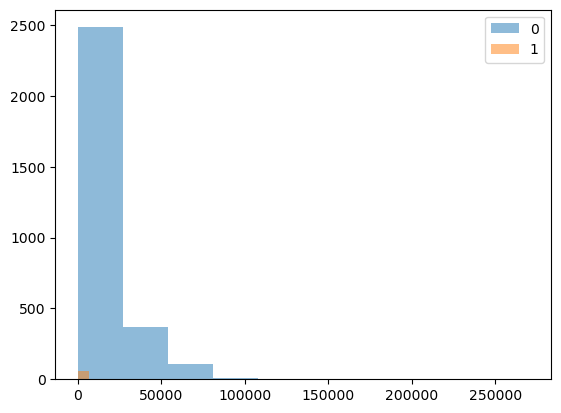

lastrejectcredamount_222A


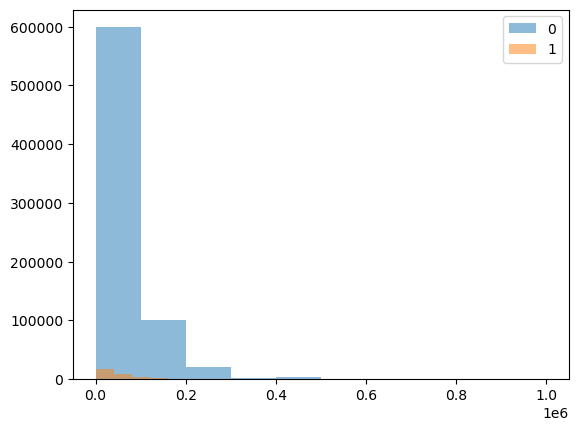

maininc_215A


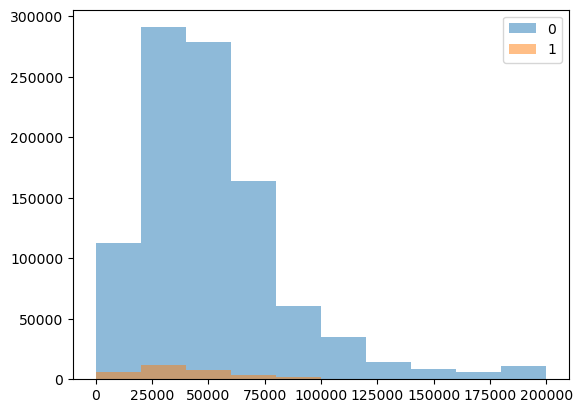

maxannuity_159A


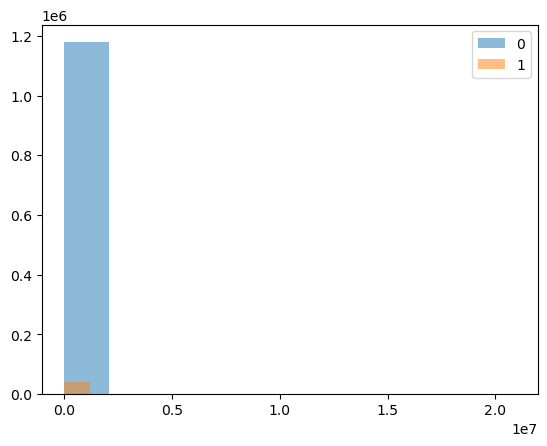

maxannuity_4075009A


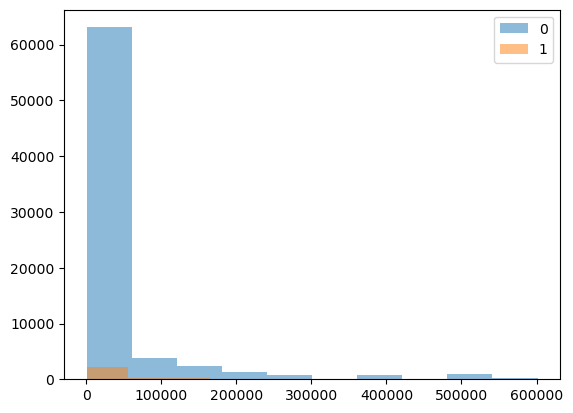

maxdebt4_972A


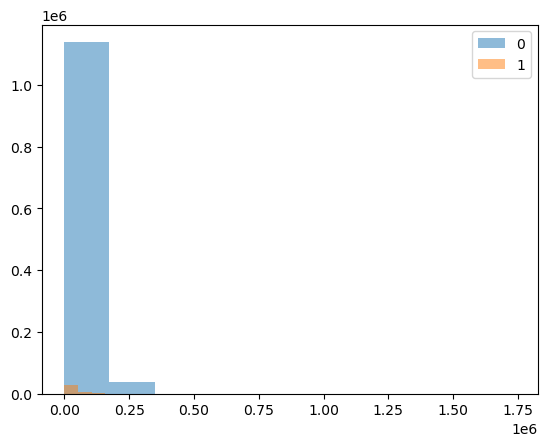

maxinstallast24m_3658928A


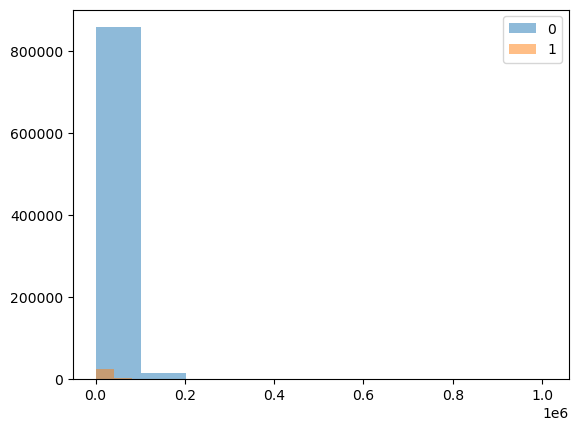

maxlnamtstart6m_4525199A


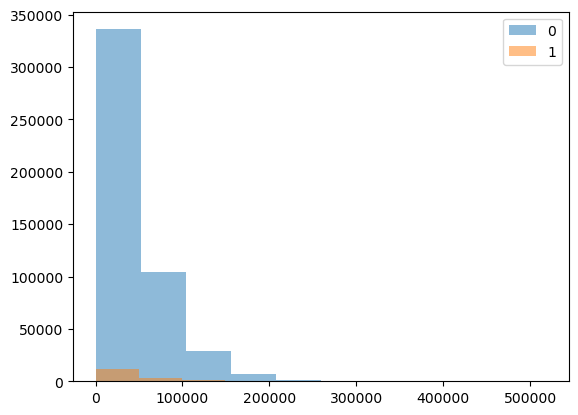

maxoutstandbalancel12m_4187113A


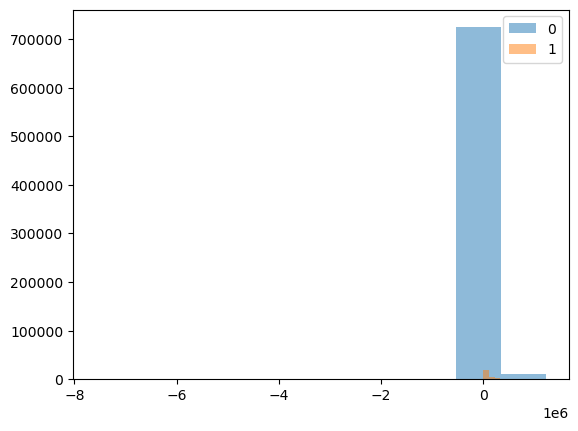

maxpmtlast3m_4525190A


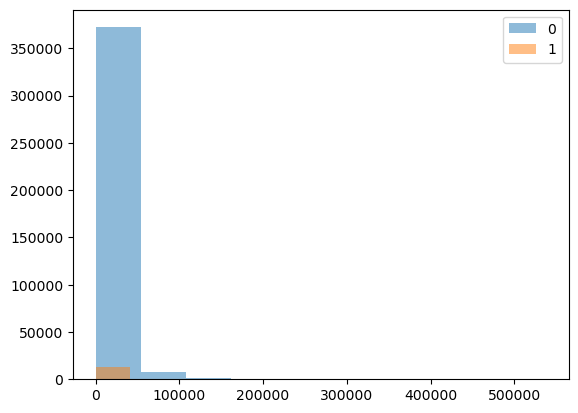

price_1097A


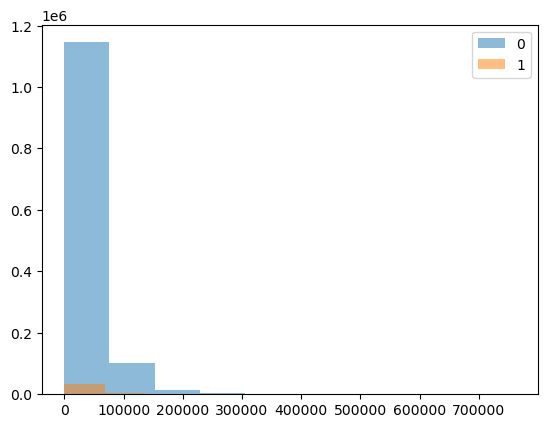

sumoutstandtotal_3546847A


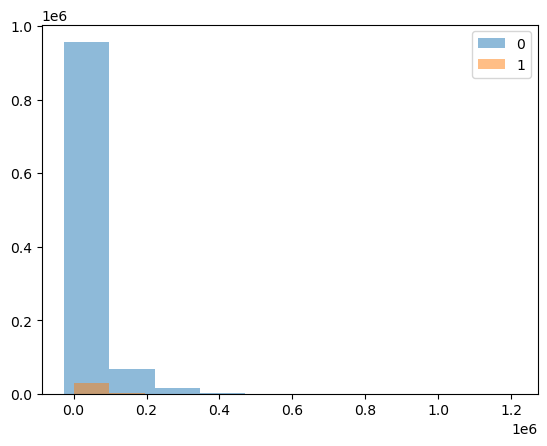

sumoutstandtotalest_4493215A


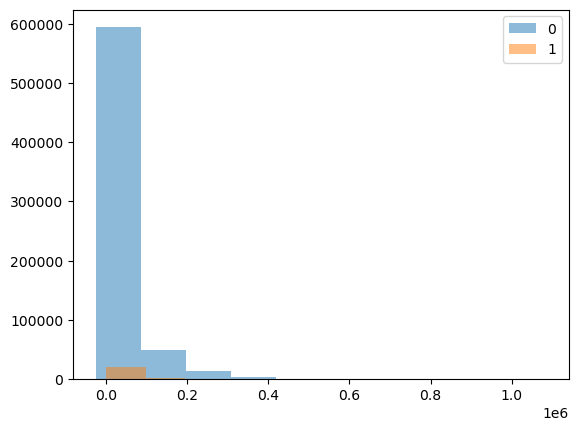

totaldebt_9A


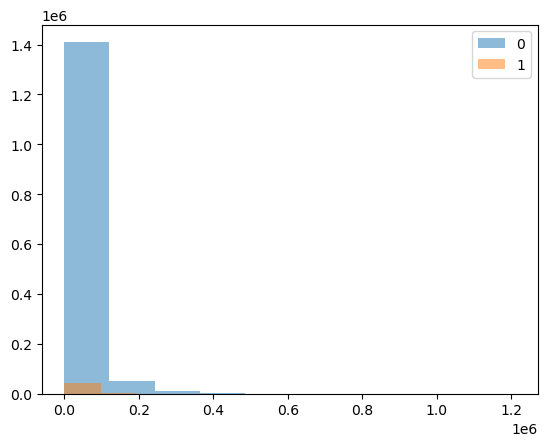

totalsettled_863A


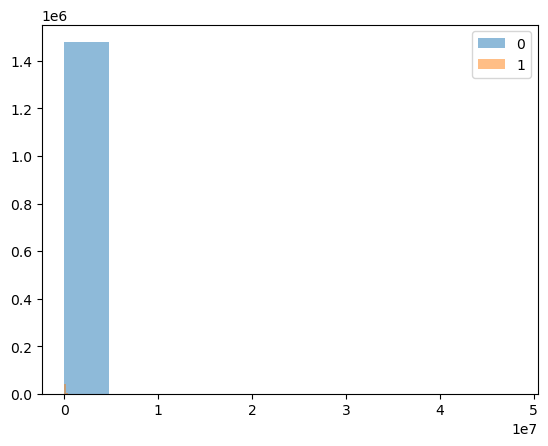

totinstallast1m_4525188A


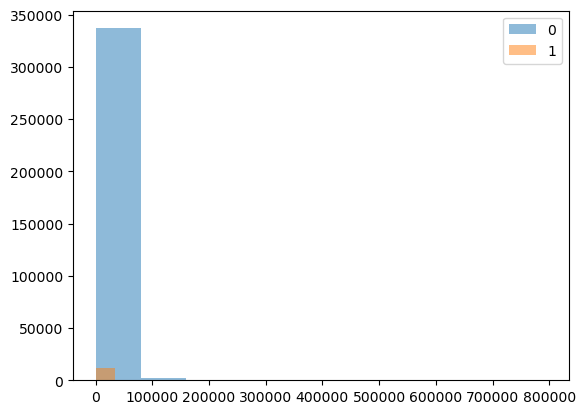

pmtaverage_3A


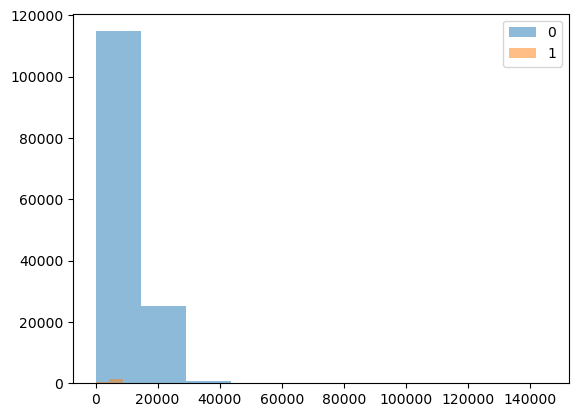

pmtaverage_4527227A


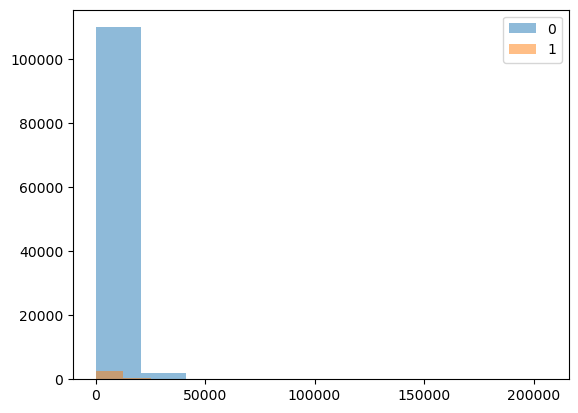

pmtaverage_4955615A


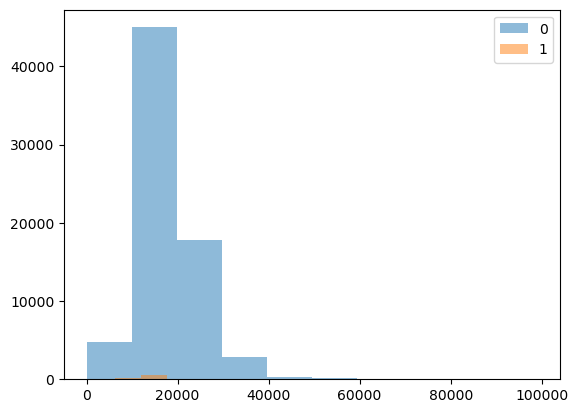

pmtssum_45A


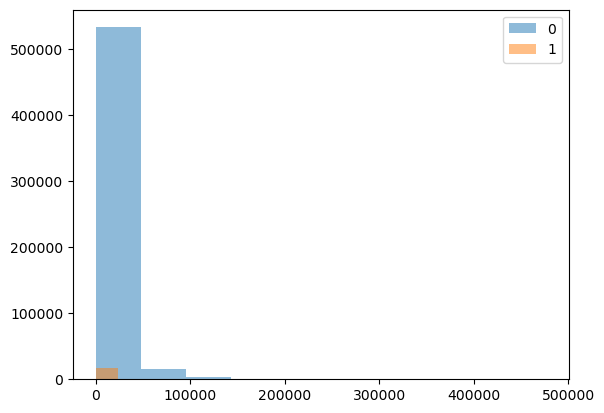

mainoccupationinc_384A_max


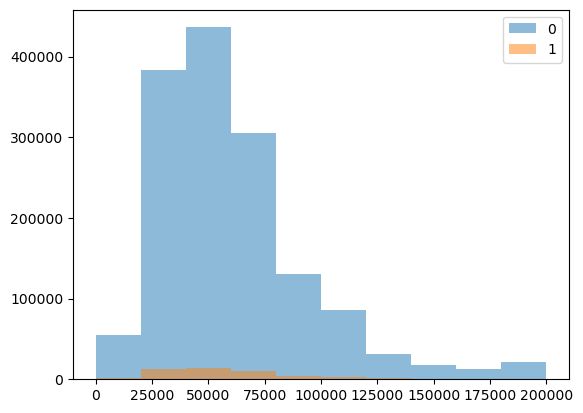

pmts_pmtsoverdue_635A_max


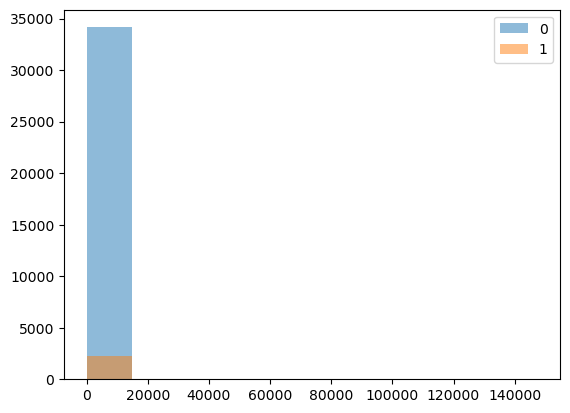

In [14]:
for col in pd_data.select_dtypes(include='number').columns:
    print(col)
    for name, group in pd_data.groupby('target'):
        plt.hist(group[col], label=name, alpha=0.5)
    plt.legend()
    plt.show()

## time series plots (might need to join more tables to find time series per person/case_id rather than over WEEK_NUMs)

In [15]:
ts_data = pd_data.groupby(['target', 'WEEK_NUM']).mean().drop(columns=['case_id', 'MONTH'])
ts_data

amtinstpaidbefduel24m_4187115A  annuity_780A  \
target WEEK_NUM                                                 
0      0                                    NaN   3398.245361   
       1                                    NaN   3677.617558   
       2                                    NaN   3663.933907   
       3                                    NaN   3642.286036   
       4                                    NaN   3746.955107   
...                                         ...           ...   
1      87                          44199.510649   4686.247474   
       88                          35827.469969   5439.270267   
       89                          40178.505945   4877.094558   
       90                          36594.589377   5016.120659   
       91                          35055.238443   4731.276451   

                 annuitynextmonth_57A  avginstallast24m_3658937A  \
target WEEK_NUM                                                    
0      0                  1062.239709                4593.046949   
       1                  1290.257265                4871.696005   
       2                  1349.501308                4925.775817   
       3                  1355.307753                4897.808957   
       4                  1373.814240                4965.963538   
...                               ...                        ...   
1      87                 1535.583606                5769.878294   
       88                 1763.890910                7468.063027   
       89                 1796.258932                5959.434876   
       90                 1556.268503                5530.103831   
       91                 1853.938908                5829.985604   

                 avglnamtstart24m_4525187A  avgoutstandbalancel6m_4187114A  \
target WEEK_NUM                                                              
0      0                               NaN                             NaN   
       1                               NaN                             NaN   
       2                               NaN                             NaN   
       3                               NaN                             NaN   
       4                               NaN                             NaN   
...                                    ...                             ...   
1      87                     63631.284163                    52401.837829   
       88                     54486.685182                    59299.512347   
       89                     42637.981476                    54575.080453   
       90                     54552.067051                    46914.201908   
       91                     60625.568684                    68504.805901   

                 avgpmtlast12m_4525200A  credamount_770A  currdebt_22A  \
target WEEK_NUM                                                          
0      0                            NaN     39545.213222  13808.446836   
       1                            NaN     44729.671995  17285.986884   
       2                            NaN     45247.500382  17919.532996   
       3                            NaN     44595.034178  18082.098070   
       4                            NaN     45368.092608  18749.554988   
...                                 ...              ...           ...   
1      87                   8843.919190     63101.762331  25324.454492   
       88                   7787.173169     70437.200030  30079.494063   
       89                   6386.115660     65411.207126  29834.195752   
       90                   7478.008089     71019.713955  24950.785782   
       91                   7022.571671     66908.435497  37076.951662   

                 currdebtcredtyperange_828A  ...  totaldebt_9A  \
target WEEK_NUM                              ...                 
0      0                        6857.564343  ...  13808.530571   
       1                       10275.323950  ...  17286.178209   
       2                       10869.540570 

### Use below plot to visualize diff columns over the weeks, change input column as necessary

note: look into the null values, are defaulted loans more likely to be null?

In [17]:
def plot_time_series(col):

    # Extract data for each target value
    target_0_data = ts_data.loc[0]  
    target_1_data = ts_data.loc[1]  

    # Plotting
    plt.figure(figsize=(10, 6))  

    # Plot for 'didn't default'
    plt.plot(target_0_data.index.get_level_values('WEEK_NUM'), target_0_data[col], label='didn\'t default')

    # Plot for 'defaulted'
    plt.plot(target_1_data.index.get_level_values('WEEK_NUM'), target_1_data[col], label='defaulted')

    plt.xlabel('Week Number')
    plt.ylabel(col)
    # plt.title('Time Series Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

Plot of number of installments paid before due date in the last 24 months

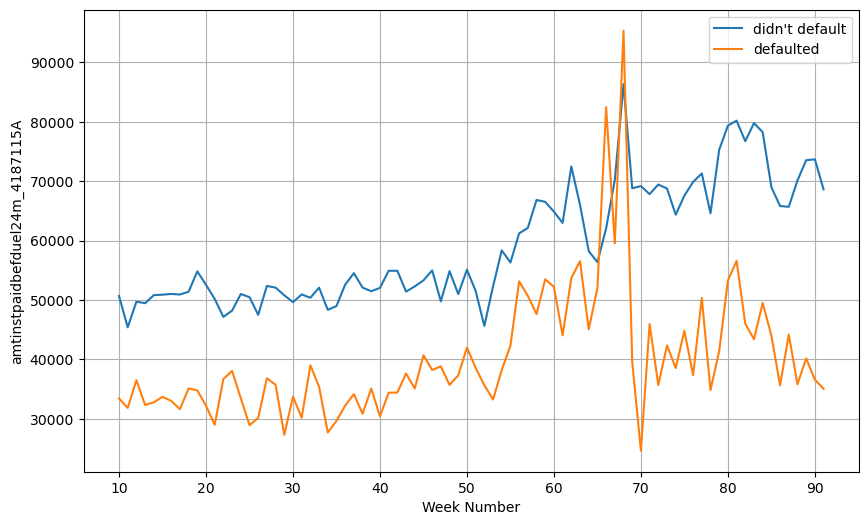

In [18]:
plot_time_series('amtinstpaidbefduel24m_4187115A')

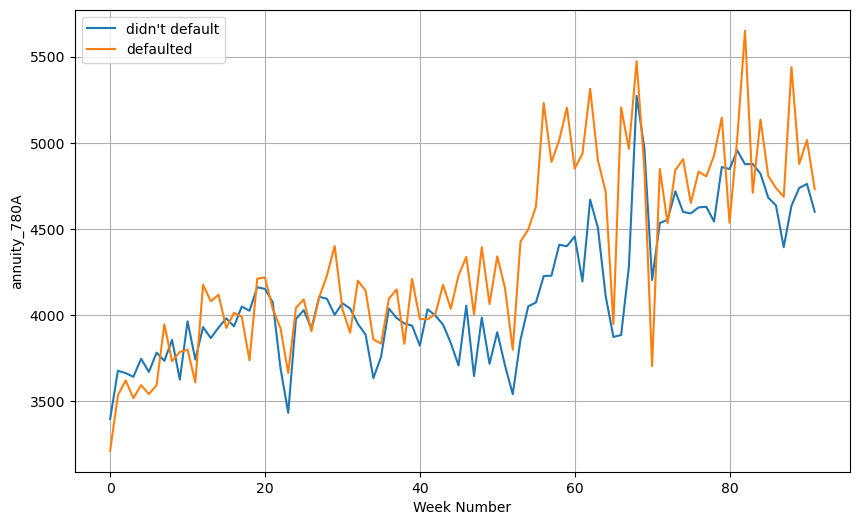

In [19]:
plot_time_series('annuity_780A')